In [1]:
from glob import glob
import os
from pathlib import Path
import shutil
import urllib.request as request
from contextlib import closing

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cartopy.feature as cfeature
from cartopy import crs as ccrs
from metpy.plots import USCOUNTIES, ctables
import cf2cdm
from datetime import datetime
from dateutil import tz

Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.


In [2]:
grib_dir = Path('.') / '..' / '..' / 'grib'
graphics_dir = Path('.') / '..' / '..' / 'graphics' / 'models' / 'href'

In [3]:
# Download files

date = 20200907
run = 18
fhr = 18
left_lon = 360-90
right_lon = 360-77
top_lat = 36
bottom_lat = 24

nomads_url = ('https://nomads.ncep.noaa.gov/cgi-bin/filter_hrefconus.pl?'
              f'file=href.t{run}z.conus.prob.f{fhr}.grib2'
              '&all_lev=on&var_VIS=on&subregion='
              f'&leftlon={left_lon}&rightlon={right_lon}&toplat={top_lat}&bottomlat={bottom_lat}&'
              f'dir=/href.{date}/ensprod')

def download_gribfilter(file_url):
    with closing(request.urlopen(file_url)) as r:
        with open(f'{grib_dir}/href/href.t{run}z.conus.prob.fog.f{fhr}.grib2', 'wb') as f:
            shutil.copyfileobj(r, f)
        
download_gribfilter(nomads_url)

In [4]:
%%capture
# Read in files and acquire data needed for plotting
ds = xr.load_dataset(f'{grib_dir}/href/href.t{run}z.conus.prob.fog.f{fhr}.grib2', engine='cfgrib',)
# ds = xr.load_dataset('href.t18z.conus.prob.f24.grib2', engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'unknown'}})
ds = ds.metpy.parse_cf()
ds = cf2cdm.translate_coords(ds, cf2cdm.CDS)

lats = ds.lat.values
lons = ds.lon.values
href_values = ds.vis.values

def convert_datetime(mrms_time):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New York')
    utc_time = datetime.strptime(mrms_time, '%Y-%m-%dT%H:%M:%S').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

VALID_TIME = convert_datetime(str(ds.time.values).split('.')[0])

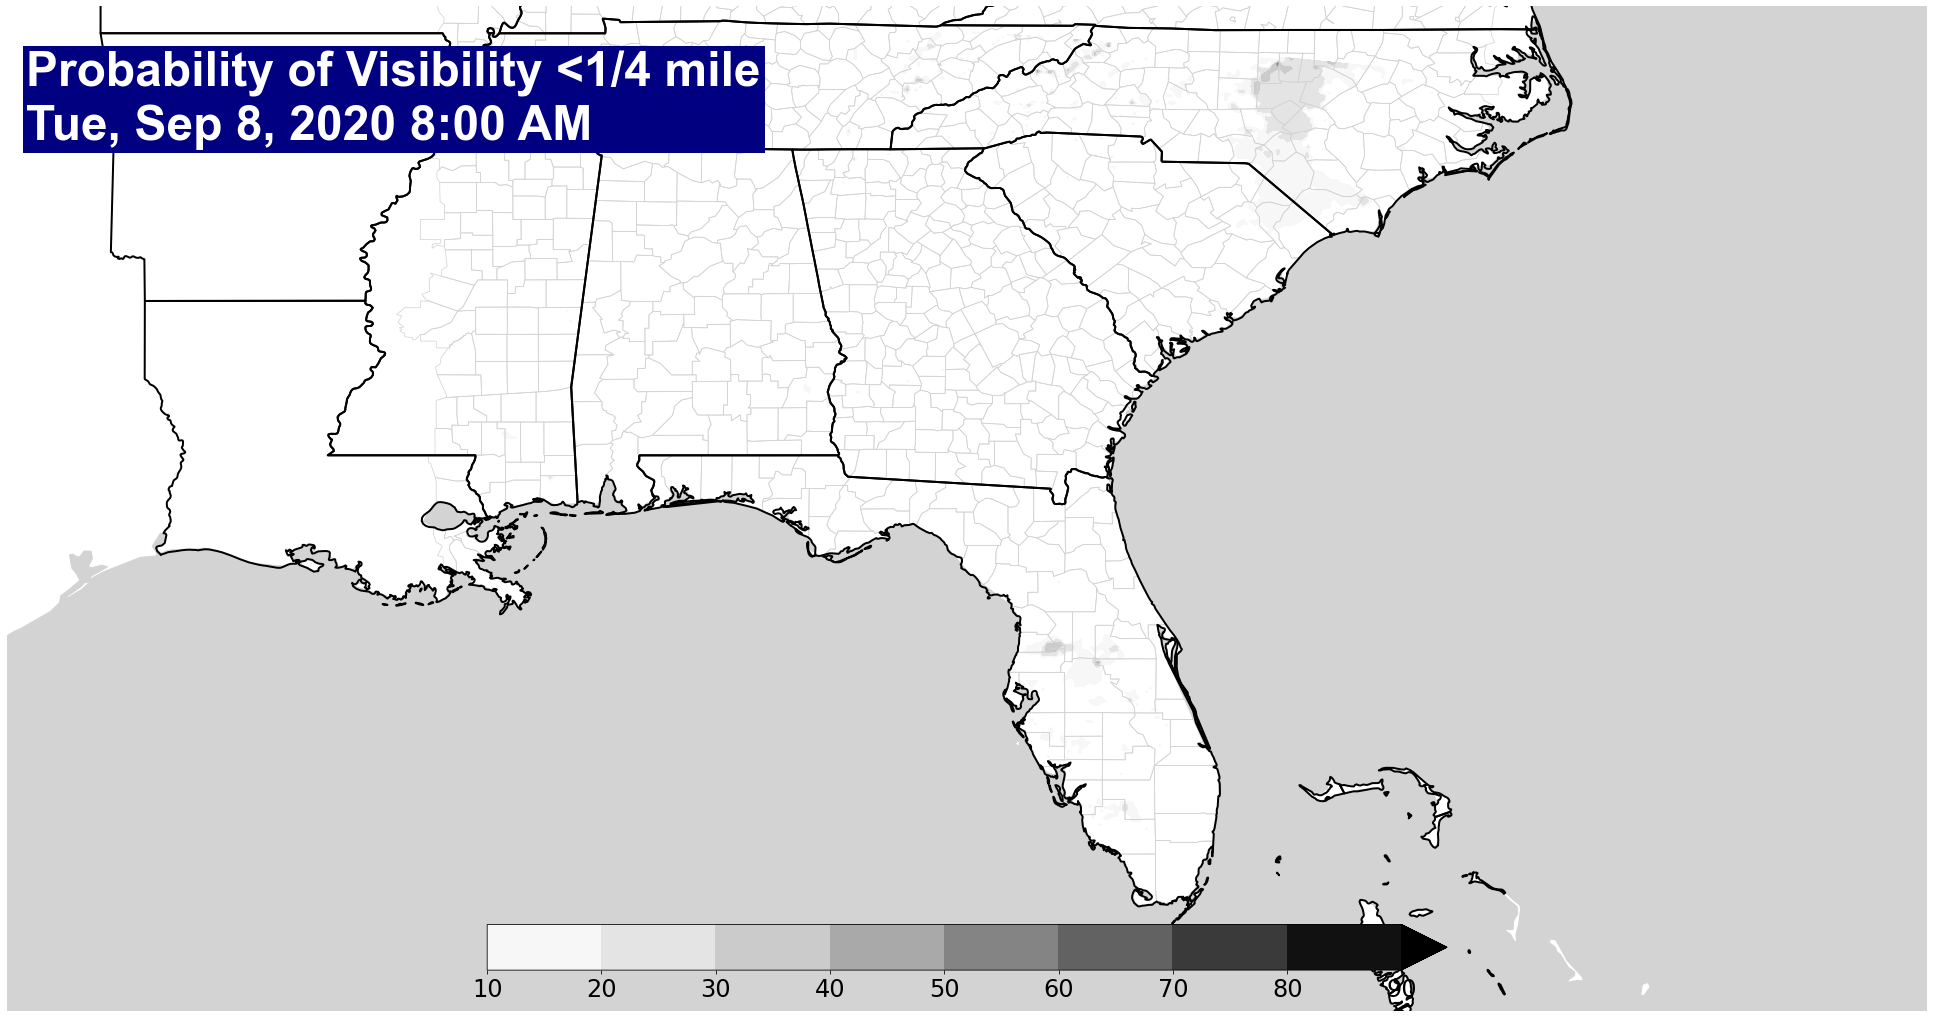

In [5]:
fig = plt.figure(figsize=(1920/72, 1080/72))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN.with_scale('50m'), color='lightgray')
ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='lightgray', linewidth=0.75)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=2.0)
ax.set_adjustable('datalim')
ax.outline_patch.set_visible(False)
#ax.set_extent([-82, -79, 31, 36])
#ax.set_extent([-87, -80, 23.5, 32])


data_range = [num for num in np.arange(10, 100, 10)]
contour = ax.contourf(lons, lats, href_values, data_range, cmap=plt.cm.Greys, 
                      extend='max', transform=ccrs.PlateCarree())

cbar = plt.colorbar(contour, orientation='horizontal', pad=-0.08, shrink=0.5,)
cbar.ax.tick_params(labelsize='24')

# Make the axis title
ax.set_title(f'Probability of Visibility <1/4 mile\n{VALID_TIME}', loc='left', 
             ha='left', va='top', fontsize=48, fontname='Arial',
             color='white', fontweight='bold', y=0.95, x=0.01,
             bbox=dict(facecolor='navy', alpha=1.0, edgecolor='none'))

# Plot cities
# cities = {
#     'Pensacola': [30.4213, -87.2169],
#     'Tallahassee': [30.4383, -84.2807],
#     'Gainesville': [29.6516, -82.3248],
#     'Tampa': [27.9506, -82.4572],
#     'Orlando': [28.5383, -81.3792],
#     'Ft Myers': [26.6406, -81.8723],
#     'Miami': [25.7617, -80.1918],
#     'Key West': [24.5551, -81.7800]
# }

# def plot_cities(lat, lon, city_name):
#     ax.text(lon, lat, city_name, fontsize=28, zorder=10, fontweight='bold', fontname='Arial', backgroundcolor='black',
#             color='white', ha='center', transform=ccrs.PlateCarree())

# for city in cities.keys():
#     plot_cities(cities[city][0], cities[city][1], city)

# Save and show figure
plt.savefig(f'{graphics_dir}/fog_{fhr}.png', dpi=72)
plt.show()